## Data Project Proposal
___

Over the last few decades, pharmaceutical companies have perfected sophisticated biochemical synthesis techniques to generate an uncountable number of drug candidates. Now it is in the initial steps of drug discovery where the greatest challenges are found. Before synthesis and testing of drug candidates, the relevant disease-causing molecular targets within the body must be identified. Recently, new tools are becoming available in the form of genomic analysis that have the potential to dramatically improve progress in this area. 

Briefly, genes are encoded in the body that inform internal mechanisms of the types of proteins that must be constructed for various biological processes to function. These proteins represent the molecular targets drug researchers are seeking. Environmental or hereditary factors can causes errors in gene encoding that lead to the development of non-communicable diseases. So by identifying the protein targets and applying an appropriate drug therapy it is possible to treat the disease.

Because of these technological advancements in genomics, a multitude of publicly-available databases now exist that describe in detail the link between genes, molecular targets, and disease. Unfortunately this information is organized in non-standard formats and accessed through file downloads, web APIs, or form-based queries. It is not easy for drug researchers to utilize these resources. Furthermore, once a target is identified there is still critical research on the business-side that needs to be performed in order to ensure profitability of the fully-developed pharmaceutical.

For these reasons I propose a project that will mate business and technical risk analysis and assist pharmaceutical companies in selecting drug development strategies that maximize the return on their R&D investment. In the first phase, I plan to compile all available gene-disease data into a central repository and develop an appropriate metric to identify the strongest gene-diseases links. In the second phase, I will search public health databases to find the rates of incidence for a long list of common and rare diseases and estimate market values. In the final phase, I will combine these two analyses to develop a list of gene targets and disease areas ranked by highest likelihood of achieving financial and technical success.
___

### Plot 1. Quality of gene-disease association data
This example plot comes from a single database (DisGeNET). The weighted scores represent a metric (0,1) that describes the quality of the established link between the identified gene and associated diseases. Each gene may influence several diseases and each diseases may be influenced by several genes. In the database I intend to construct, the number of diseases linked to a particular gene will influence the gene's 'drug development score'.

There are dozens of similar independently constructed databases that need to be scraped or downloaded.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

In [12]:
file = 'all_gene_disease_associations.txt.gz'


# Roll through gzip csv file using pandas reader
reader = pd.read_csv(file, sep='\t', compression='gzip', iterator=True, chunksize=10000)

# Concatenate to build dataframe
df = pd.concat(reader, ignore_index=True)

In [18]:
# Inspect first and last 3 entries
dfview = pd.concat((df[:3],df[-3:]),axis=0,ignore_index=True)
dfview

,geneId,geneSymbol,geneName,diseaseId,diseaseName,score,NumberOfPubmeds,associationType,source
0,540,ATP7B,"ATPase, Cu++ transporting, beta polypeptide",umls:C0019202,Hepatolenticular Degeneration,0.972607,200,"AlteredExpression, Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, LHGDN, MGD, R..."
1,4160,MC4R,melanocortin 4 receptor,umls:C0028754,Obesity,0.940000,264,"Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, MGD, RGD, UNI..."
2,3667,IRS1,insulin receptor substrate 1,umls:C0011860,"Diabetes Mellitus, Type 2",0.907216,112,"Biomarker, GeneticVariation","BeFree, CLINVAR, CTD_human, GAD, MGD, RGD, UNI..."
3,3690,ITGB3,"integrin, beta 3 (platelet glycoprotein IIIa, ...",umls:C0751711,Anterior ischemic optic neuropathy,0.000284,1,Biomarker,BeFree
4,4524,MTHFR,methylenetetrahydrofolate reductase (NAD(P)H),umls:C0751711,Anterior ischemic optic neuropathy,0.000284,1,Biomarker,BeFree
5,161882,ZFPM1,"zinc finger protein, FOG family member 1",umls:C1845837,Dyserythropoietic Anemia with Thrombocytopenia,0.000284,1,GeneticVariation,BeFree


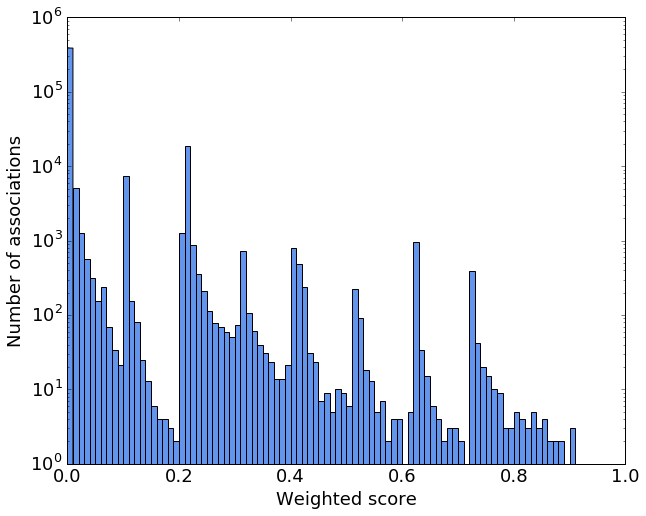

In [10]:
bins = np.arange(0,1.01,0.01)
color = 'CornflowerBlue'


plt.rc('font', size='18')
# plt.ioff()

fig, ax = plt.subplots(1, figsize=(10,8))
ax.set_xlabel('Weighted score')
ax.set_ylabel('Number of associations')
ax.set_yscale("log", nonposy='clip')
_,_,_ = plt.hist(dfc3['score'], bins=bins, color=color)

plt.show()

In [ ]:
# Mean score of all disease

In [89]:
# Number of genes per disease
dfdis = df[['diseaseName','geneSymbol']].groupby(['diseaseName'], sort=False).count()
dfdis.columns = ['Number of genes']
dfdis.sort_values('Number of genes', inplace=True)
dfdis.tail()

,Number of genes
diseaseName,
Carcinogenesis,3398
Breast Carcinoma,3983
Malignant neoplasm breast,4219
Primary malignant neoplasm,5095
"NEOPLASM, MALIGNANT",5689


In [77]:
# dfdis = dfdis[dfdis['Number of genes']==1].sort_index()
print(dfdis.shape)
dfdis.tail()

(5424, 1)


,Number of genes
diseaseName,
vegetative state,1
visceral myopathy,1
vomit recurrent,1
"von Willebrand disease, type IIC",1
"von Willebrand disease, type IID",1


In [90]:
dfscore = df[['diseaseName','score','geneName']].drop_duplicates('diseaseName').set_index('diseaseName')
print(dfscore.shape)
dfscore.head()

(14586, 2)


,score,geneName
diseaseName,,
Hepatolenticular Degeneration,0.972607,"ATPase, Cu++ transporting, beta polypeptide"
Obesity,0.940000,melanocortin 4 receptor
"Diabetes Mellitus, Type 2",0.907216,insulin receptor substrate 1
Rett Syndrome,0.900000,methyl CpG binding protein 2
Cystic Fibrosis,0.900000,cystic fibrosis transmembrane conductance regu...


In [121]:
dfscoredis = pd.concat((dfdis,dfscore),axis=1,ignore_index=False).dropna()
print(dfscoredis.shape)
dfscoredis.sort_values('score',ascending=False).head()

(14586, 3)


,Number of genes,score,geneName
Hepatolenticular Degeneration,42,0.972607,"ATPase, Cu++ transporting, beta polypeptide"
Obesity,1693,0.940000,melanocortin 4 receptor
"Diabetes Mellitus, Type 2",1716,0.907216,insulin receptor substrate 1
Cystic Fibrosis,401,0.900000,cystic fibrosis transmembrane conductance regu...
Rett Syndrome,119,0.900000,methyl CpG binding protein 2


In [306]:
# Select higher quality data by removing lower scores and high number of genes
dfthresh = dfscoredis.copy()
dfthresh = dfthresh[(dfthresh['Number of genes']<5) & (dfthresh['score']>0.7)]
# print(dfthresh.shape)

In [305]:
# Identify disease incidence rate from nih genetics database 
dfthresh.sort_values('score', ascending=False, inplace=True)
idx = dfthresh.index[:100].tolist()
print(idx)

dburl = 'http://ghr.nlm.nih.gov/condition/'
urls = [dburl+str.lower(s.replace(' ','-')) for s in idx]
# print(len(urls))

incid = []
for url in urls:

    # Request content from web page
    result = requests.get(url)
    c = result.content

    # Set as Beautiful Soup Object
    soup = BeautifulSoup(c, "lxml")
    res = soup.find_all("div",{'class':'freepp'})
    if len(res) == 0:
        res = [None, 'Disease not found in database. May be known by a different name.']
    holder = BeautifulSoup(str(res[1]),"lxml").get_text()
    incid.append(holder.replace('\n',''))

['Canavan Disease', 'Cleidocranial Dysplasia', 'Glycogen Storage Disease Type IIb', 'Primary hyperoxaluria type 1', 'Mucopolysaccharidosis VII', 'Biotinidase Deficiency', 'Alkaptonuria', 'Oculocutaneous albinism type 1', 'Focal Dermal Hypoplasia', 'Congenital contractural arachnodactyly', 'Papillorenal syndrome', 'Paralysis, Hyperkalemic Periodic', 'Ulnar-mammary syndrome', 'Blepharophimosis, Ptosis, and Epicanthus Inversus', 'Autosomal Dominant Lateral Temporal Lobe Epilepsy', 'Triglyceride storage disease with impaired long-chain fatty acid oxidation', 'Vitamin D Hydroxylation-Deficient Rickets, Type 1A', 'Allan-Herndon-Dudley syndrome', 'Episodic Ataxia, Type 1', 'Giant Axonal Neuropathy', 'Lymphedema distichiasis syndrome', 'Systemic carnitine deficiency', 'Hyperparathyroidism 1', 'Glycogen Storage Disease IB', 'Lipoid congenital adrenal hyperplasia', 'Bestrophinopathy', 'alpha-Mannosidosis', 'Platelet Glycoprotein IV Deficiency', 'Muscular dystrophy congenital, merosin negative', 

In [307]:
# dfthresh.head(10)
incidser = pd.Series(incid, index=idx, name='Incidence')
dfincid = pd.concat((dfthresh, incidser), axis=1, ignore_index=False)
dfincid.sort_values('score', ascending=False, inplace=True)
dfincid.head(20)

,Number of genes,score,geneName,Incidence
Canavan Disease,4,0.839553,aspartoacylase,While this condition occurs in people of all e...
Cleidocranial Dysplasia,3,0.763477,runt-related transcription factor 2,Cleidocranial dysplasia occurs in approximatel...
Glycogen Storage Disease Type IIb,4,0.741969,lysosomal-associated membrane protein 2,Disease not found in database. May be known by...
Primary hyperoxaluria type 1,4,0.738144,alanine-glyoxylate aminotransferase,Disease not found in database. May be known by...
Mucopolysaccharidosis VII,4,0.734742,"glucuronidase, beta",Disease not found in database. May be known by...
Biotinidase Deficiency,4,0.733854,biotinidase,Profound or partial biotinidase deficiency occ...
Alkaptonuria,1,0.733834,"homogentisate 1,2-dioxygenase","This condition is rare, affecting 1 in 250,000..."
Oculocutaneous albinism type 1,3,0.733325,tyrosinase,Disease not found in database. May be known by...
Focal Dermal Hypoplasia,2,0.732671,porcupine homolog (Drosophila),Focal dermal hypoplasia appears to be a rare c...
Congenital contractural arachnodactyly,3,0.730539,fibrillin 2,The prevalence of congenital contractural arac...


In [ ]:
# Generate colors for graphs
colorseq = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
            '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
            '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
            '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']